## Setup: 
Setup conda/mamba environment as specified in https://github.com/LorenFrankLab/spyglass/blob/master/environment.yml

In [1]:
import datajoint as dj
import sys
import os

# dj.config['database.host'] = "" # enter datajoint host url
# dj.config['database.user'] = "" # enter datajoint username
# dj.config['database.port'] = 3306
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")

from spyglass.common.common_behav import StateScriptFile
from spyglass.common.common_task import TaskEpoch
from spyglass.common.common_nwbfile import AnalysisNwbfile
sys.path.append("..")
from trials import TrialInfo

[2024-03-16 18:27:50,039][INFO]: Connecting molly@gl-ash.biostr.washington.edu:3306
[2024-03-16 18:27:50,063][INFO]: Connected molly@gl-ash.biostr.washington.edu:3306


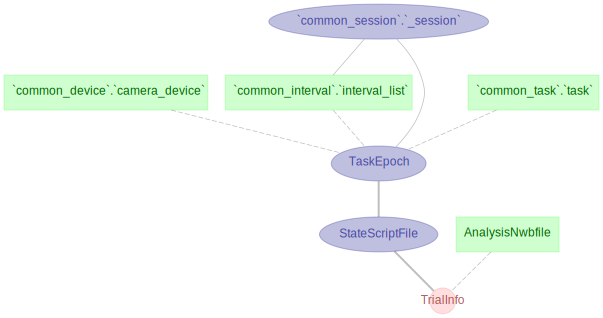

In [2]:
dj.Diagram(TaskEpoch) + dj.Diagram(TrialInfo) - 1

In [3]:
TrialInfo.heading

# 
nwb_file_name        : varchar(64)                  # name of the NWB file
epoch                : int                          # the session epoch for this task and apparatus(1 based)
---
analysis_file_name   : varchar(64)                  # name of the file
trial_info_object_id : varchar(40)                  # the NWB object ID for loading this object from the file
parser               : varchar(100)                 # type of parser used to interpret statescript log
descriptors=null     : blob                         # global descriptors for task

## Inserting epochs from a single session:
Normally this would be auto computed from each entry in StateScriptFile, but for now we can test inserting a single session

In [2]:
nwb_file_name = 'bobrick20231114_.nwb'

In [5]:
TrialInfo.populate(StateScriptFile & {'nwb_file_name' : nwb_file_name})

[18:15:22][INFO] Spyglass: Skipping sleep epoch: 01_s1


bug trial #108, epoch 2! line 256: index 0 is out of bounds for axis 0 with size 0
bug trial #129, epoch 2! line 194: index 0 is out of bounds for axis 0 with size 0


[18:15:23][INFO] Spyglass: Writing new NWB file bobrick20231114_LW316LW0AV.nwb
[18:15:25][INFO] Spyglass: Skipping sleep epoch: 03_s2


bug trial #108, epoch 4! line 256: index 0 is out of bounds for axis 0 with size 0
bug trial #128, epoch 4! line 194: index 0 is out of bounds for axis 0 with size 0


[18:15:25][INFO] Spyglass: Writing new NWB file bobrick20231114_TZP4BSBHUJ.nwb
[18:15:27][INFO] Spyglass: Skipping sleep epoch: 05_s3


In [6]:
TrialInfo()

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,trial_info_object_id the NWB object ID for loading this object from the file,parser type of parser used to interpret statescript log,descriptors global descriptors for task
bobrick20231114_.nwb,2,bobrick20231114_LW316LW0AV.nwb,0858636e-01f3-46c5-9dcd-8987adde33ff,V8_delay,=BLOB=
bobrick20231114_.nwb,4,bobrick20231114_TZP4BSBHUJ.nwb,dfe2ffe9-c84d-401e-a7fc-f97c6426bc40,V8_delay,=BLOB=


In [7]:
# The resulting entry in AnalysisNwbfile that was generated
(AnalysisNwbfile & {"nwb_file_name" : "bobrick20231114_.nwb"})

analysis_file_name name of the file,nwb_file_name name of the NWB file,analysis_file_abs_path the full path to the file,analysis_file_description an optional description of this analysis,analysis_parameters additional relevant parameters. Currently used only for analyses
bobrick20231114_LW316LW0AV.nwb,bobrick20231114_.nwb,=BLOB=,,=BLOB=
bobrick20231114_TZP4BSBHUJ.nwb,bobrick20231114_.nwb,=BLOB=,,=BLOB=


## Reading the resulting analysis file

In [8]:
# select a specific epoch for the inserted session
restr = {"nwb_file_name": "bobrick20231114_.nwb", "epoch": 2}

In [9]:
# accessing trial descriptors
(TrialInfo & restr).fetch1("descriptors")

{'statescript': 'V8pre_delay_locknoise_uw.sc',
 'lockout_period': 30.0,
 'python_script': 'V8.py',
 'outer_reps': 15,
 'num_goals': 1,
 'forage_num': 1}

In [5]:
# retrieve a dataframe containing info from each trial on the selected epoch
(TrialInfo & restr).fetch1_dataframe()

,start_time,end_time,lockout_starts,lockout_ends,during_lockout,lockout_type,rw_start,rw_end,leave_home,leave_rw,trial_type,outer_well,outer_time,leave_outer,outer_success,goal_well,rw_success
id,,,,,,,,,,,,,,,,,
1,1.699984e+09,1.699984e+09,[1699984390.1323001],[1699984420.1323001],"[11, 9]",3.0,1.699984e+09,1.699984e+09,1.699984e+09,1.699984e+09,2.0,0,0.000000e+00,0.000000e+00,0.0,5.0,0.0
2,1.699984e+09,1.699985e+09,[1699984475.5333002],[1699984505.5333002],"[2, 9]",1.0,1.699984e+09,1.699984e+09,1.699984e+09,1.699984e+09,2.0,0,0.000000e+00,0.000000e+00,0.0,5.0,1.0
3,1.699985e+09,1.699985e+09,[1699984538.3913],[1699984568.3913],[7],3.0,1.699985e+09,1.699985e+09,1.699985e+09,1.699985e+09,2.0,0,0.000000e+00,0.000000e+00,0.0,5.0,0.0
4,1.699985e+09,1.699985e+09,[],[],[],0.0,1.699985e+09,1.699985e+09,1.699985e+09,1.699985e+09,2.0,10,1.699985e+09,1.699985e+09,0.0,5.0,1.0
5,1.699985e+09,1.699985e+09,[],[],[],0.0,1.699985e+09,1.699985e+09,1.699985e+09,1.699985e+09,2.0,6,1.699985e+09,1.699985e+09,0.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,1.699989e+09,1.699989e+09,[1699988858.1123002],[1699988888.1123002],[3],1.0,1.699989e+09,1.699989e+09,1.699989e+09,1.699989e+09,1.0,0,0.000000e+00,0.000000e+00,0.0,0.0,1.0
137,1.699989e+09,1.699989e+09,[1699988908.8423002],[1699988938.8423002],[8],3.0,1.699989e+09,1.699989e+09,1.699989e+09,1.699989e+09,1.0,0,0.000000e+00,0.000000e+00,0.0,0.0,0.0
138,1.699989e+09,1.699989e+09,[1699989257.8203],[1699989287.8203],[8],1.0,1.699989e+09,1.699989e+09,1.699989e+09,1.699989e+09,1.0,0,0.000000e+00,0.000000e+00,0.0,0.0,1.0


In [13]:
# option: run this cell to get an interactive plot (only works in jupyter, not vscode)
%matplotlib notebook

Using matplotlib backend: <object object at 0x7faab38e17d0>


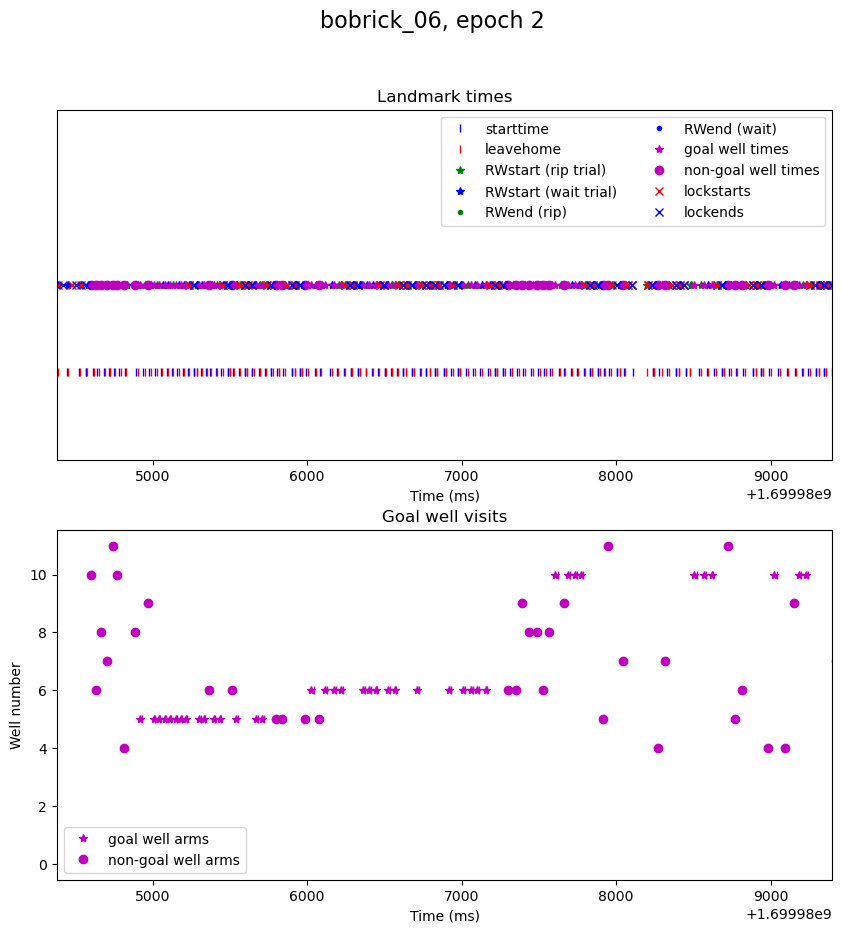

In [6]:
# optional: visualize landmark times during epoch
(TrialInfo & restr).plot_trials()

## Deleting Entries

In [4]:
# Deletes TrialInfo entries from this session
(TrialInfo & {"nwb_file_name" : "bobrick20231114_.nwb"}).delete()

[2024-03-16 18:13:10,515][INFO]: Deleting 2 rows from `TrialsInfo`.`__trial_info`


[2024-03-16 18:13:11,969][INFO]: Deletes committed.


2

In [5]:
TrialInfo & {"nwb_file_name" : "bobrick20231114_.nwb"}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,trial_info_object_id the NWB object ID for loading this object from the file,parser type of parser used to interpret statescript log,descriptors global descriptors for task


In [6]:
# Automatically deletes AnalysisNwbfile entries that are not referenced a downstream table
# AND removes the filepath entries for NWB files that are not in use.
AnalysisNwbfile.nightly_cleanup()

100%|██████████| 4/4 [00:00<00:00, 93.11it/s]
